# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from math import radians, sin, cos, asin, sqrt
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

1. ~Создать признаки для Price Range.~
2. ~Создать признаки для населения по городам и площади городов.~
3. ~Спарсить средний чек и время питания~
4. ~Посмотреть ***Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города***, ***Number of Reviews — количество отзывов о ресторане***.~
5. ~Попробывать спарсить расстояние от центра города до ресторана. На https://www.tripadvisor.ru/ есть координаты ресторанов, на https://www.google.com/maps/ парсятся центры городов~.
6. ~Спрарсить страны на Яндекс.Картах~
7. Аномальные признаки? Заполнение пропусков (кухни - стоит ли?) EDA графики.
8. ~Зарегаться на Kaggle.~
9. ~Обработать отзывы на тональность. Ну эт пиздец...~
10. Столица или нет?
11. 

In [2]:
df = pd.read_csv('main_task.csv')

# очистка столбца виды кухонь
pattern = re.compile('\w+\s*\w*')
df['Cuisine Style'].fillna('no_information', inplace=True)
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: pattern.findall(x))

#создание столбца Cuisine Count - колическтво кухонь в ресторане
df['Cuisine Count'] = df['Cuisine Style'].apply(lambda x: len(x))

# очистка столбца с отзывами
pattern = re.compile('\d+[-]\d+[-]\d+')
df['Reviews'] = df['Reviews'].apply(lambda x: str(x).split(','))
df['Reviews'] = df['Reviews'].apply(lambda x: str(x).replace('/', '-'))
df['Reviews'] = df['Reviews'].apply(lambda x: pattern.findall(x))

df['Reviews'] = df['Reviews'].apply(lambda x: pd.to_datetime(x))
df['Reviews'] = df['Reviews'].apply(lambda x: np.nan if len(x) == 0 else x)

#создание столбца diff_day - разница между отзывами в днях
df['dif_day'] = df['Reviews'][df['Reviews'].isnull() == False].apply(lambda x: x[0] - x[-1])
df['dif_day'] = df['dif_day'].apply(lambda x: x.days)

df.loc[df['City'] == 'Oporto', 'City'] = 'Porto'

In [3]:

df['Price Range'] = df['Price Range'].apply(lambda x: 'low_price' if x == '$' else x)
df['Price Range'] = df['Price Range'].apply(lambda x: 'medium_price' if x == '$$ - $$$' else x)
df['Price Range'] = df['Price Range'].apply(lambda x: 'high_price' if x == '$$$$' else x)

In [4]:
#борьба с нулевыми значениями
df['Number of Reviews'] = df['Number of Reviews'].fillna(df['Number of Reviews'].median())
df['dif_day'] = df['dif_day'].fillna(df['dif_day'].median())

In [5]:
df.head(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Cuisine Count,dif_day
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,medium_price,194.0,"DatetimeIndex(['2017-12-31', '2017-11-20'], dt...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,41.0
1,id_1535,Stockholm,[no_information],1537.0,4.0,NaN,10.0,"DatetimeIndex(['2017-07-06', '2016-06-19'], dt...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,382.0


In [6]:
#создаём признаки по населению и площади городов
data = [[2.2, 105], [1, 188], [8.9, 1706], 
         [3.6, 891], [1.5, 310], [0.3, 41,4], 
         [1.4, 181], [0.4, 368], [1.9, 414], 
         [2.9, 1287], [1.7, 101], [3.3, 607], 
         [1.2, 117], [0.2, 32.6], [0.4, 88], 
         [1.8, 517], [1.8, 525], [0.8, 86.4], 
         [0.9, 219], [0.5, 48], [1.9, 755], 
         [0.5,100], [1.3, 496], [0.7, 454], 
         [0.7,213], [0.5, 120], [0.2, 16], 
         [0.3, 163], [0.7, 39], [0.125, 51.5], 
         [0.8, 327]]
cities = df.City.unique()
city_dict = {}
for i in range(len(cities)):
    city_dict[cities[i]] = data[i] 

df['city_pop'] = df['City'].apply(lambda x: city_dict[x][0])
df['city_val'] = df['City'].apply(lambda x: city_dict[x][-1])

In [7]:
# загружаем данные с парсинга
# городов
data_city = pd.read_csv('cities.csv')
pattern_coord = re.compile('\d+[.]\d+')
data_city.city_coord = data_city.city_coord.apply(
    lambda x: pattern_coord.findall(x))
data_city.city_coord = data_city.city_coord.apply(
    lambda x: [float(x[0]), float(x[1])])
# ресторанов
data_rest = pd.read_csv('rest_pars.csv')
pattern_text = re.compile('\w+\s*\w*')
data_rest.meals = data_rest.meals.apply(
    lambda x: pattern_text.findall(x) if type(x) == str else x)
data_rest.rub_max = data_rest.rub_max.apply(
    lambda x: float(x) if type(x) == str else x)
data_rest.rest_coord = data_rest.rest_coord.apply(
    lambda x: pattern_coord.findall(x) if type(x) == str else x)

df = df.merge(data_city)
df = df.merge(data_rest, how = 'outer')

In [8]:
data_capitals = pd.read_csv('capitals.csv')

In [9]:
df

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Cuisine Count,dif_day,city_pop,city_val,country,city_coord,meals,rest_coord,rub_max,rub_min
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,medium_price,194.0,"DatetimeIndex(['2017-12-31', '2017-11-20'], dt...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,41.0,2.2,105.0,France,"[48.856663, 2.351556]","[Lunch, Dinner, Brunch, Breakfast, Late Night]","[48.8316299, 2.3397946]",3503.0,1314.0
1,id_10057,Paris,[no_information],10059.0,4.5,NaN,4.0,"DatetimeIndex(['2011-08-20'], dtype='datetime6...",/Restaurant_Review-g187147-d2040769-Reviews-Le...,d2040769,1,0.0,2.2,105.0,France,"[48.856663, 2.351556]",NaN,"[48.8716425, 2.3769562]",NaN,NaN
2,id_11291,Paris,[French],11293.0,4.5,medium_price,10.0,"DatetimeIndex(['2015-03-08'], dtype='datetime6...",/Restaurant_Review-g187147-d3543081-Reviews-La...,d3543081,1,0.0,2.2,105.0,France,"[48.856663, 2.351556]",NaN,NaN,NaN,NaN
3,id_5459,Paris,"[Asian, Thai, Vegetarian Friendly]",5460.0,3.5,medium_price,132.0,"DatetimeIndex(['2017-10-18', '2017-07-29'], dt...",/Restaurant_Review-g187147-d953033-Reviews-Cha...,d953033,3,81.0,2.2,105.0,France,"[48.856663, 2.351556]",NaN,"[48.8573944, 2.3547866]",3224.0,2125.0
4,id_9924,Paris,[Pub],9926.0,3.5,low_price,39.0,"DatetimeIndex(['2017-02-14', '2017-12-10'], dt...",/Restaurant_Review-g187147-d5799345-Reviews-Th...,d5799345,1,-299.0,2.2,105.0,France,"[48.856663, 2.351556]",NaN,"[48.842526, 2.3237937]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_651,Krakow,"[Italian, Pizza]",652.0,4.0,medium_price,28.0,"DatetimeIndex(['2017-10-10', '2015-10-15'], dt...",/Restaurant_Review-g274772-d3626236-Reviews-Tr...,d3626236,2,726.0,0.8,327.0,Poland,"[50.061971, 19.936742]","[Dinner, Lunch, Brunch]","[50.0673113, 19.9709151]",NaN,NaN
39996,id_355,Krakow,"[Italian, Mediterranean, Vegetarian Friendly]",356.0,4.0,medium_price,201.0,"DatetimeIndex(['2017-11-12', '2017-06-28'], dt...",/Restaurant_Review-g274772-d1929643-Reviews-La...,d1929643,3,137.0,0.8,327.0,Poland,"[50.061971, 19.936742]","[Lunch, Dinner]","[50.0601897, 19.9363463]",NaN,NaN
39997,id_283,Krakow,"[Italian, Pizza, European, Vegetarian Friendly...",284.0,4.0,medium_price,340.0,"DatetimeIndex(['2017-12-20', '2017-10-23'], dt...",/Restaurant_Review-g274772-d1098691-Reviews-Fa...,d1098691,5,58.0,0.8,327.0,Poland,"[50.061971, 19.936742]","[Lunch, Dinner, Late Night]","[50.0512498, 19.9468592]",NaN,NaN
39998,id_800,Krakow,[no_information],801.0,4.5,NaN,11.0,"DatetimeIndex(['2016-10-05', '2016-06-08'], dt...",/Restaurant_Review-g274772-d3899509-Reviews-Pi...,d3899509,1,119.0,0.8,327.0,Poland,"[50.061971, 19.936742]",NaN,NaN,NaN,NaN


In [10]:
capitals = []

for i in data_capitals['0']:
    capitals.append(i)

df['is_capital'] = df['City'].apply(lambda x: 1 if x in capitals else 0)

In [11]:
df.rub_max.fillna(0, inplace=True)
df.rub_min.fillna(0, inplace=True)
df['rub_range'] = df.rub_max
df['rub_range'] = df.rub_range.apply(lambda x: 0 if x == 0 else 1)

In [12]:
def haversine(lon1, lat1, lon2, lat2):
    if lon1 != np.nan or lat1 != np.nan or lon2 != np.nan or lat2 != np.nan:
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
        c = 2 * asin(sqrt(a))
        earth_radius = 6371
        dist = c * earth_radius
    else:
        dist = np.nan
    return dist

In [13]:
df['city_lon'] = df.city_coord.apply(lambda x: x[0])
df['city_lat'] = df.city_coord.apply(lambda x: x[1])
df['rest_lon'] = df.rest_coord.apply(lambda x: float(x[0]) if type(x) == list else x)
df['rest_lat'] = df.rest_coord.apply(lambda x: float(x[1]) if type(x) == list else x)

In [14]:
df['distance'] = df.apply(lambda row: 
                                    haversine(lon1 = row['city_lon'], 
                                              lat1 = row['city_lat'],
                                              lon2 = row['rest_lon'], 
                                              lat2 = row['rest_lat']), 
                                      axis=1)

In [15]:
df['distance'] = df['distance'].apply(lambda x: x if x < 20 else np.nan)
df.distance.fillna(method='ffill', inplace = True)

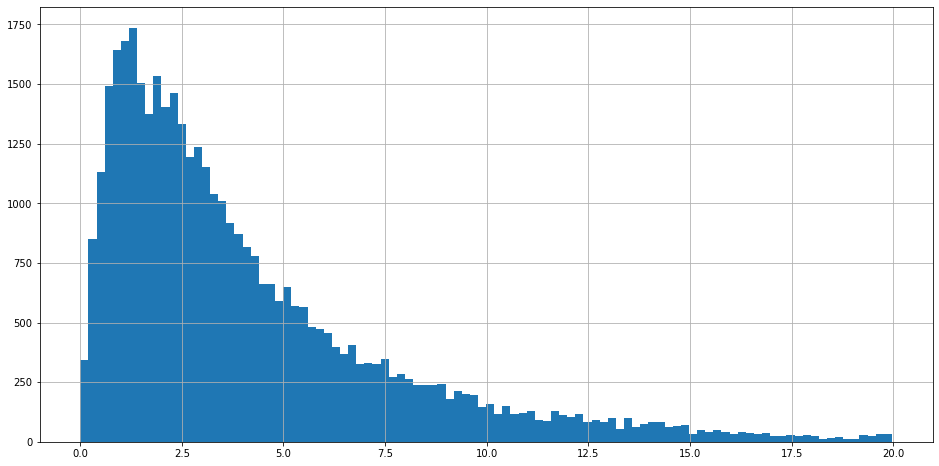

In [33]:
plt.figure(figsize=(16, 8))
df.distance.hist(bins=100)

In [17]:
df['meals_count'] = df['meals'].apply(lambda x: len(x) if type(x) == list else np.nan)
df['meals_count'].fillna(0, inplace = True)

In [18]:
def is_local_cuisine(row):
    local_cuisine_by_country = {
        'United Kingdom':['British','Scottish'],
        'Spain': ['Spanish'],
        'France': ['French','Central European'], 
        'Italy': ['Italian','Central European'],
        'Germany': ['Dutch','German','Central European'],
        'Portugal': ['Portuguese'],
        'Czech Republic': ['Czech','Eastern European'],
        'Poland':['Polish','Eastern European'],
        'Austria': ['Austrian','Central European'],
        'Netherlands':['Scandinavian'],
        'Belgium': ['Belgian','Eastern European'],
        'Switzerland':['Swiss','Central European'],
        'Sweden':['Scandinavian'],
        'Hungary':['Hungarian','Eastern European'],
        'Ireland':['Irish'],
        'Denmark':['Scandinavian'],
        'Greece':['Greece'],
        'Norway':['Scandinavian'],
        'Finland':['Scandinavian'],
        'Slovakia':['Eastern European'],
        'Luxembourg':['Eastern European'],
        'Slovenia':['Slovenian','Eastern European']
    }
    loc_cus = local_cuisine_by_country[row['country']]
    for l in loc_cus:
        if l in row['Cuisine Style'] and l != '':
            return 1
    else:
        return 0
    return 0

df['local_cuisine'] = df.apply(is_local_cuisine, axis = 1)

In [20]:
df.ID_TA = df.ID_TA.apply(lambda x: float(x[1:]))

In [34]:
plt.figure(figsize=(16, 10))  # размер графика
d = df.drop(['Restaurant_id', 'Cuisine Style', 'City',
             'Price Range', 'Reviews', 'URL_TA', 'country',
             'city_coord', 'rest_coord', 'meals', 'rub_max', 'rub_min',
             'city_lon', 'city_lat', 'rest_lon', 'rest_lat'], axis=1)

matrix = np.triu(d.corr())
sns.heatmap(d.corr(), annot=True, vmin=-1, vmax=1,
            center=0, square=True, mask=matrix)

NameError: name 'cold' is not defined

<Figure size 1152x720 with 0 Axes>

In [22]:
#Создание Dummy - переменных
df = df.merge(pd.get_dummies(df['Price Range']), left_index=True, right_index=True)
df = df.merge(pd.get_dummies(df['City']), left_index=True, right_index=True)
df = df.merge(pd.get_dummies(df['country']), left_index=True, right_index=True)

cuisines = []

for i in df['Cuisine Style']:
    for j in range(len(i)):
        cuisines.append(i[j])

top_cuisines = pd.Series(cuisines).value_counts()[:30].index

for i in top_cuisines:
    df[i+' cuisine'] = df['Cuisine Style'].apply(lambda x: 1 if i in x else 0)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [23]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating', 'Cuisine Style', 'City',
             'Price Range', 'Reviews', 'URL_TA', 'country', 
             'city_coord', 'rest_coord', 'meals', 'rub_max', 'rub_min', 
             'city_lon', 'city_lat', 'rest_lon','rest_lat', 'distance'], axis=1)
y = df['Rating']

In [24]:
pd.set_option('display.max_columns', None)
X

,Ranking,Number of Reviews,ID_TA,Cuisine Count,dif_day,city_pop,city_val,is_capital,rub_range,meals_count,local_cuisine,high_price,low_price,medium_price,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg_x,Lyon,Madrid,Milan,Munich,Oslo,Paris,Porto,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Austria,Belgium,Czech Republic,Denmark,Finland,France,Germany,Greece,Hungary,Ireland,Italy,Luxembourg_y,Netherlands,Norway,Poland,Portugal,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom,Vegetarian Friendly cuisine,European cuisine,no_information cuisine,Mediterranean cuisine,Italian cuisine,Vegan Options cuisine,Gluten Free cuisine,Options cuisine,Bar cuisine,French cuisine,Asian cuisine,Pizza cuisine,Spanish cuisine,Pub cuisine,Cafe cuisine,Fast Food cuisine,British cuisine,International cuisine,Seafood cuisine,Japanese cuisine,Central European cuisine,American cuisine,Sushi cuisine,Chinese cuisine,Portuguese cuisine,Indian cuisine,Middle Eastern cuisine,Thai cuisine,Wine Bar cuisine,German cuisine
0,5570.0,194.0,1912643.0,3,41.0,2.2,105.0,1,1,5.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,10059.0,4.0,2040769.0,1,0.0,2.2,105.0,1,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,11293.0,10.0,3543081.0,1,0.0,2.2,105.0,1,0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5460.0,132.0,953033.0,3,81.0,2.2,105.0,1,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,9926.0,39.0,5799345.0,1,-299.0,2.2,105.0,1,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,652.0,28.0,3626236.0,2,726.0,0.8,327.0,0,0,3.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39996,356.0,201.0,1929643.0,3,137.0,0.8,327.0,0,0,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39997,284.0,340.0,1098691.0,5,58.0,0.8,327.0,0,0,3.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39998,801.0,11.0,3899509.0,1,119.0,0.8,327.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [27]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [28]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [29]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

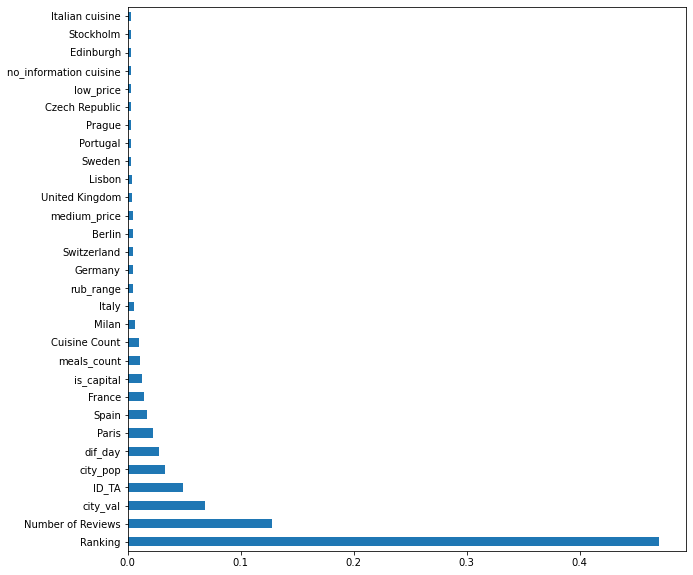

In [30]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [31]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', round(metrics.mean_absolute_error(y_test, y_pred),5))

#0.38
#0.211
# 0.20952
# 0.21045
#0.21091
#0.21644

MAE: 0.21244
